# Adventureworks försäljningsanalys

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Lejonkatt123!")
server = 'localhost:1434'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\shara\AppData\Local\Temp\ipykernel_24272\2655009714.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)
    

## Analys 1 - Antal produkter per kategori
**Affärsfråga: Hur många produkter finns i varje kategori?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna antal unika ProductID inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med vertikalt stapeldiagram med etiketter ovanför varje stapel
4. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som har flest/minst produkter.**

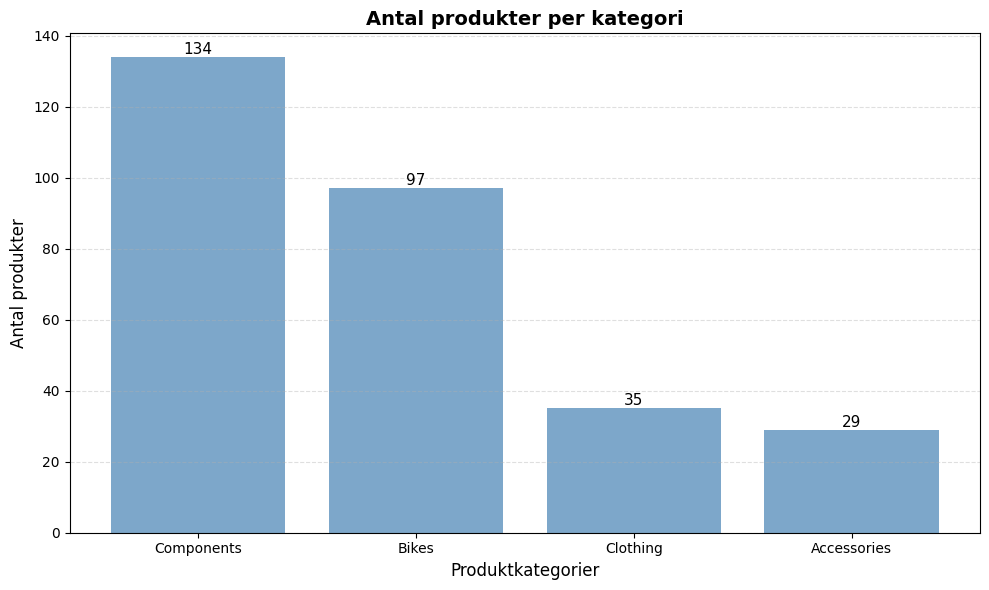

In [3]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='steelblue', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha = 'center',
        va = 'bottom',
        fontsize=11
    ) 

ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategorier',fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12 )
ax.grid(axis='y',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Resultatet visar att **Components** har flest produkter (134). Detta indikerar att Adventure Works har ett brett utbud av komponenter, vilket är logiskt för ett cykelföretag där delar som ramar, pedaler och andra komponenter är centrala för anpassning.  
Det kan även visa på ett fokus kring reparationer och uppgraderingar som driver återkommande försäljning.

Kategorin **Accessories** har minst (29) vilket tyder på att tillbehör såsom tex. hjälmar är ett mindre fokusområde. Ett utökat sortimentet inom både kläder och accesoarer skulle potentiellt kunna skapa ökade möjligheter till merförsäjning.

## Analys 2 - Försäljning per produktkategori
**Affärsfråga: Vilka produktkategorier genererar mest intäkter?**

Tabeller som används: Production.ProductCategory, Production.ProductSubcategory, Production.Product, Sales.SalesOrderDetail

**Plan**
1. JOINA tabellerna för att hämta Kategorinamn och räkna ut totalsumman av ordrar inom varje kategori
2. Göra om min Query till en Dataframe
3. Visualisera resultatet med horisontellt stapeldiagram, sortera från högst till lägst (högsta överst)
4. Skriva ut största och minsta kategori med exakta siffror då detta är en del av kravet
4. Analysera resultatet - Krav på insikt: **Förklara vilken kategori som är störst och minst, med exakta siffror.**

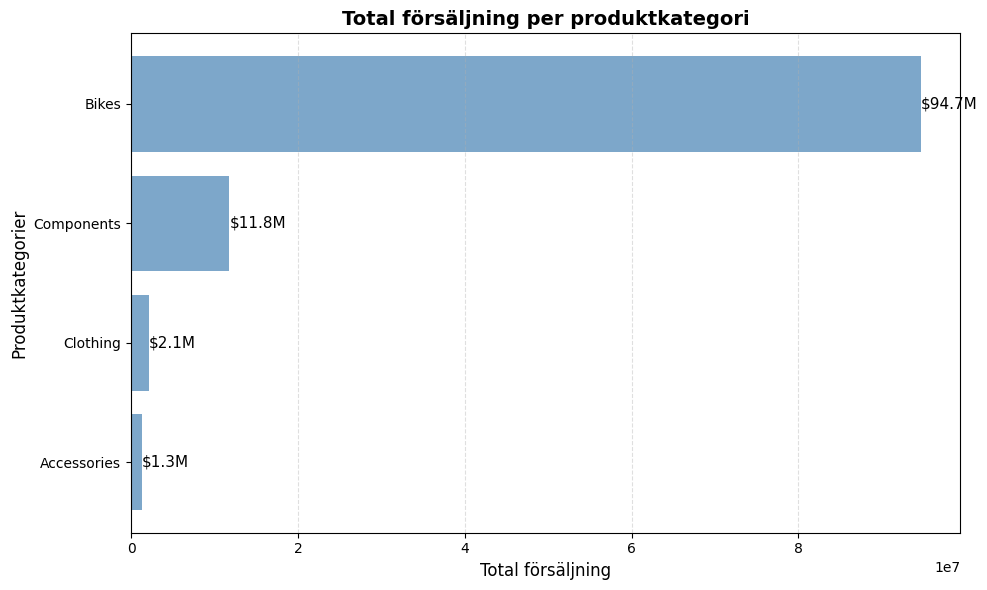

Största kategori: Bikes med totala försäljningen: $ 94,651,172.704731
Minsta kategori: Accessories med totala försäljningen: $ 1,272,072.883926


In [32]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID 
GROUP BY pc.Name
ORDER BY TotalSales DESC 
"""

df_vis2 = query_df(query_vis2)

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(df_vis2['CategoryName'][::-1], df_vis2['TotalSales'][::-1], color='steelblue', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width +1,
        bar.get_y() + bar.get_height()/2,
        f'${width/1_000_000:.1f}M',
        va = 'center',
        ha = 'left',
        fontsize=11
    ) 

ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning',fontsize=12)
ax.set_ylabel('Produktkategorier', fontsize=12 )
ax.grid(axis='x',linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Största kategori: {df_vis2.iloc[0]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[0]['TotalSales']:,}")
print(f"Minsta kategori: {df_vis2.iloc[-1]['CategoryName']} med totala försäljningen: $ {df_vis2.iloc[-1]['TotalSales']:,}")
#print(f'Största kategori: {(df_vis2.loc[max_idx,'CategoryName'])} med summan: $ {(df_vis2['TotalSales']).max()} \nMinsta totalsumman är {(df_vis2['CategoryName']).min()} med summan: $ {(df_vis2['TotalSales']).min()} ')

### Insikter - Försäljning per produktkategori
Den klart strörsta produktkategorin är **Bikes** med en total försäljning på ca **$94,7 M**.   
Detta visar att kärnverksamheten – försäljning av cyklar – är den största drivkraften bakom AdventureWorks framgång.  
Företaget är därmed starkt beroende av Bikes-kategorin och eventuella svägningar i cykelförsäljningen (t.ex. på grund av säsong eller konkurrens) kan påverka hela företagets resultat betydligt

Den minsta kategorin är **Accessories** med endast ca **$1,3 M** i total försäljning. Detta visar att försäljningen i denna kategori är relativt låg jämfört med huvudkategorin och utgör endast en mindre del av företagets intäkter.  




## Analys 3 - Försäljningstrend över tid
**Affärsfråga: Hur har försäljningen utvecklats över tid?**

In [5]:
# Kod

### Insikter - Försäljningstrend över tid

## Analys 4 - Försäljning och antal ordrar per år
**Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?**

In [6]:
# Kod

### Insikter - Försäljning och antal ordrar per år

## Analys 5 -  Top 10 produkter
**Affärsfråga:  Vilka 10 produkter genererar mest försäljning?**

In [7]:
# Kod

### Insikter - Top 10 produkter

## Analys 6 - Försäljning och antal kunder per region
**Affärsfråga: Hur skiljer sig försäljningen mellan olika regioner, och hur många unika kunder har varje region?**

In [8]:
# Kod

### Insikter - Försäljning och antal kunder per region

## Analys 7 - Genomsnittligt ordervärde per region och kundtyp
**Affärsfråga: Vilka regioner har högst/lägst genomsnittligt ordervärde, och skiljer det sig mellan individuella kunder och företagskunder?**

In [9]:
# Kod

### Insikter - Genomsnittligt ordervärde per region och kundtyp